<a id="subcluster_T_and_NK"></a>
## Sub-cluster T cells and NKs

Autosaving every 60 seconds
scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


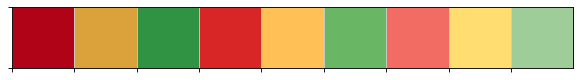

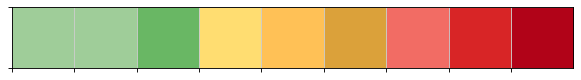

In [83]:
%matplotlib inline
%autosave 60
#%load_ext autoreload
#%autoreload 2


import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../../Code')
from utils import save_adata, read_adata, pca_cytof
results_dir = '../../../../../results'

import palettable
from IPython.display import display

from joblib import parallel_backend

from scipy.stats import ranksums

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(colors)
sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]



In [2]:
adir = '../../../../../data/InVivo/Cytof/'
project_name = 'Full_IRF_SerialSac_Cytof_Fixid.1M'
gcs = False

In [3]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')

In [4]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [5]:
adata

AnnData object with n_obs × n_vars = 943558 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'leiden', 'leiden10_colors', 'leiden12_colors', 'leiden13_colors', 'leiden14_colors', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca

In [6]:
adata.obs['leiden_lab_group'].unique()

[Mono/DC, Neut, HLA-DR_high, Th, B, Plasmablast, NK, Tc, Doublet, RBC]
Categories (10, object): [Mono/DC, Neut, HLA-DR_high, Th, ..., NK, Tc, Doublet, RBC]

In [7]:
adata_T = adata[adata.obs['leiden_lab_group'].isin(['Th', 'Tc', 'NK']),:]

In [8]:
adata_T = adata_T.copy()

In [9]:
adata_T.obsm = None

In [10]:
adata_T.obs.columns

Index(['BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1',
       'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI',
       'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode',
       'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1',
       'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5',
       'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width',
       'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context',
       'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab',
       'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample',
       'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12',
       'Subclustering', 'SubclusteringGroup', 'Doublet'],
      dtype='object')

In [11]:
adata_T.obs['leiden_lab'].value_counts()

Th 1    208541
Tc 1    181878
NK 1     34636
Th 2     14009
Tc 2      6092
Th 3       452
Name: leiden_lab, dtype: int64

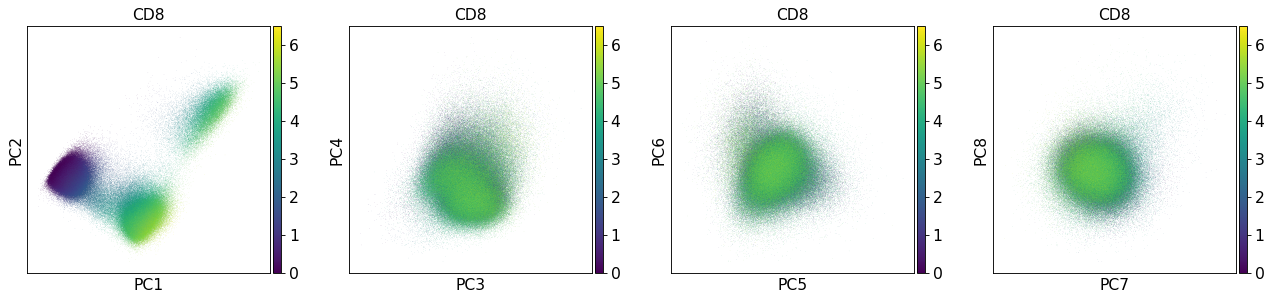

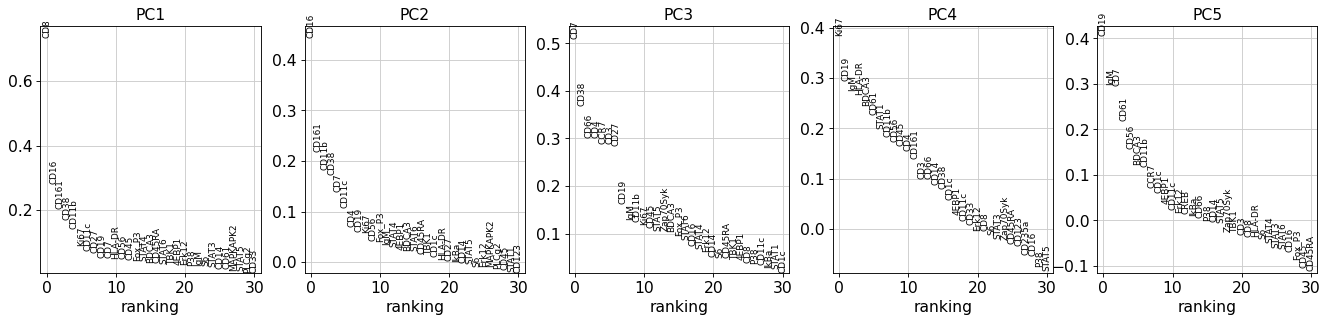

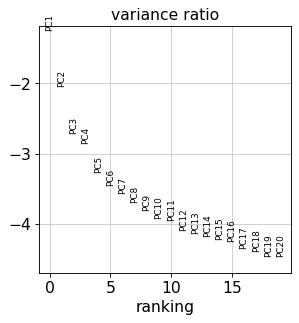

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:20:25)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (1:39:53)


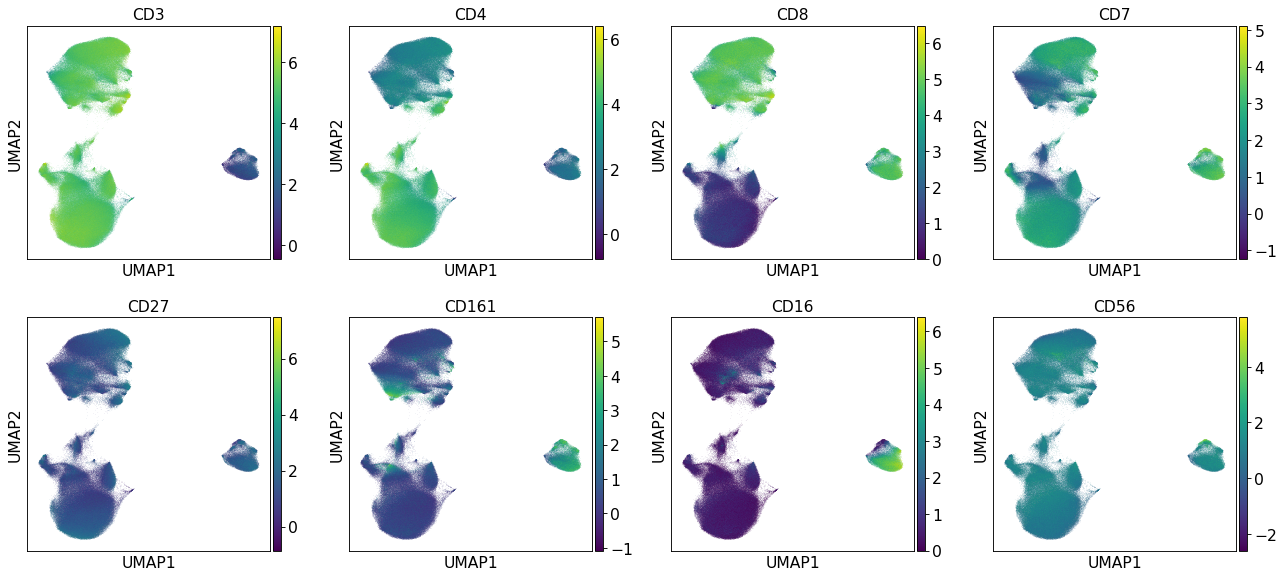

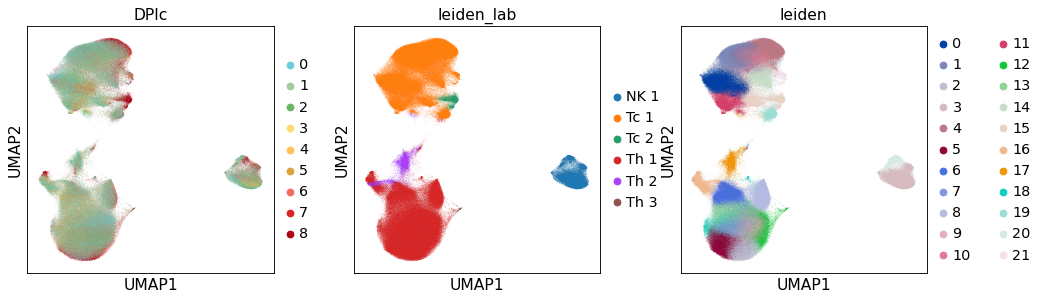

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,CD8,CD8,CD4,CD16,CD27,CD4,CD4,CD38,CD61,CREB,...,CD4,STAT1,CD61,Ki67,Ki67,CD4,CD19,CD45,CD161,CD19
1,CD235a,CD7,CD27,CD161,CCR7,CD38,STAT1,CD4,BDCA3,CD4,...,IkBa,CD4,BDCA3,CD8,CD4,CD235a,CD4,CD3,CD38,IgM
2,CD123,CREB,CD3,CD11b,CD8,CD3,CD235a,CREB,IgM,STAT3,...,PLCg2,CD7,IgM,CD45,CD45,CD33,CD66,CD66,CD19,CD27
3,CD33,CCR7,CD7,CD11c,STAT6,CD66,CD33,CD56,CD4,CD3,...,Fox_P3,CD56,CD8,CD38,HLA-DR,CD123,CD3,CD8,CD7,CD7
4,STAT3,STAT3,CD66,CD38,CD7,CCR7,CD123,CD3,CD19,STAT5,...,MAPKAPK2,CD45,CD11b,HLA-DR,STAT1,CD45,IgM,CD19,CD11c,CD38
5,HLA-DR,P38,STAT6,CD7,Fox_P3,CD7,CD45,CD66,CD11b,Erk12,...,STAT6,CREB,CD19,STAT1,CD14,HLA-DR,CD11b,CD7,CD11b,CD161
6,PLCg2,Erk12,CCR7,Fox_P3,CD3,STAT6,CD56,P38,CD1c,S6,...,CD235a,CD235a,HLA-DR,CD14,IgM,STAT1,CCR7,CD11b,Ki67,4EBP1
7,MAPKAPK2,IkBa,Fox_P3,STAT4,CD66,Fox_P3,CD61,CD7,CD11c,P38,...,CD45RA,CD33,CD11c,BDCA3,CD61,STAT3,CD56,CD27,CD56,CD56


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,167.592361,182.203400,202.141998,288.109528,201.690598,196.280487,142.101257,97.800072,210.980209,129.132507,...,54.073128,123.421867,182.595276,193.666901,172.785294,94.962395,122.143394,122.485405,103.736771,93.920235
1,117.059883,109.392143,127.429840,245.265488,181.591782,143.087082,122.507446,83.659386,145.155060,101.853172,...,19.273376,120.730530,135.918671,152.443817,104.860809,50.357471,106.157555,118.113976,89.290337,62.015282
2,89.131035,61.043327,111.991379,233.670029,160.785355,124.994995,89.935394,51.941109,118.756203,55.508892,...,7.850888,63.792351,105.582314,119.263191,90.600899,32.657688,90.937462,113.448822,80.007767,55.649639
3,88.229630,49.590290,105.179665,228.130753,126.066391,108.214294,67.803116,40.773788,72.357758,51.362934,...,5.321817,37.693748,105.564789,93.513138,57.042046,31.874510,76.960480,87.701714,77.275856,51.218594
4,74.524734,42.194607,95.046417,221.587784,123.104683,81.179695,53.916286,24.687847,62.265110,40.879734,...,0.116999,31.951212,78.621071,90.109131,53.401882,29.839859,73.912582,79.065697,74.058197,40.002750
5,65.888306,25.054302,87.352112,166.484146,123.009033,80.378212,40.533485,12.382866,61.899796,35.281548,...,-0.804078,27.188602,60.850784,74.303535,38.346508,22.212523,52.377113,68.231880,64.044106,31.092955
6,59.231964,20.434618,85.368492,144.149200,110.649246,70.686028,35.442181,7.013817,61.792885,30.404915,...,-1.061101,21.914150,55.246708,69.532593,33.970566,18.577200,46.770412,66.372513,61.539539,26.498102
7,47.683563,14.350660,80.667526,139.244385,106.271141,62.481533,34.501316,-1.412925,51.463287,28.827909,...,-4.921081,3.969725,53.813267,66.892548,33.690128,18.251114,42.779163,64.406601,59.064850,24.765385


In [12]:

umap_genestoplot=['CD3', 'CD4', 'CD8', 'CD7', 'CD27', 'CD161', 'CD16', 'CD56']
_adata = adata_T.copy()
npcs=10
n_neighbors=int(_adata.shape[0]*.0001)
min_dist=0.1
spread=2.0
resolution=2.0
pc_genestoplot=['CD8']
other_plot=['DPIc', 'leiden_lab', 'leiden']
random_state=14

pca_cytof(_adata)
sc.pl.pca(_adata, components=['1,2', '3,4', '5,6', '7,8'], color=pc_genestoplot,
          ncols=4)
sc.pl.pca_loadings(_adata, components=[1,2,3,4,5])
sc.pl.pca_variance_ratio(_adata, log=True)

sc.pp.neighbors(_adata, n_neighbors=n_neighbors, n_pcs=npcs, random_state=random_state,
                    use_rep='X_pca')
sc.tl.umap(_adata, min_dist=min_dist, spread=spread, random_state=random_state)
np.random.seed(random_state)
sc.tl.leiden(_adata, resolution=resolution, random_state=random_state)


fig = sc.pl.umap(_adata, color=umap_genestoplot)
fig = sc.pl.umap(_adata, color=other_plot)

sc.tl.rank_genes_groups(_adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(_adata.uns['rank_genes_groups']['names']).head(8))
display(pd.DataFrame(_adata.uns['rank_genes_groups']['scores']).head(8))
adata_T_1 = _adata.copy()

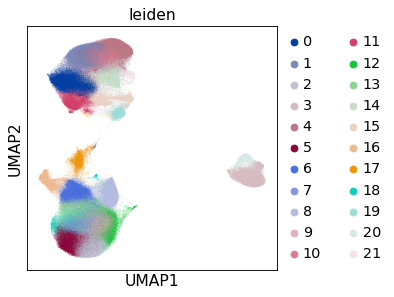

In [18]:
sc.pl.umap(adata_T_1, color='leiden')

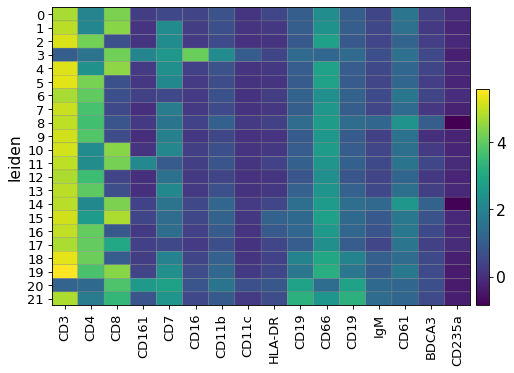

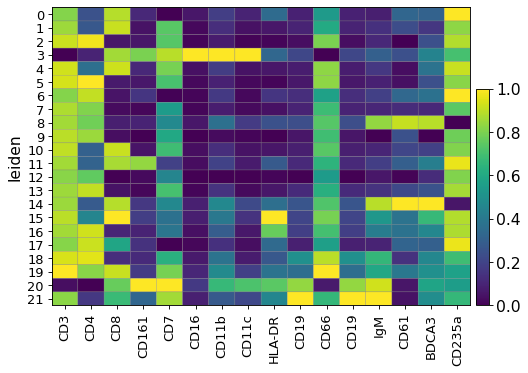

In [14]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD7', 'CD16', 'CD11b', 'CD11c', 'HLA-DR', 'CD19', 'CD66', 'CD19', 'IgM', 'CD61', 'BDCA3', 'CD235a']
gs = sc.pl.matrixplot(adata_T_1,marker_genes, groupby='leiden', figsize=(7,5))
gs = sc.pl.matrixplot(adata_T_1,marker_genes, groupby='leiden', figsize=(7,5), standard_scale='var')

In [30]:
main = ['Tc', 'Tc', 'Th', 'NK', 'Tc', #0-4
        'Th', 'Th', 'Th', 'Th', 'Th', #5-9
        'Tc', 'Tc', 'Th', 'Th', 'Tc', #10-14
        'Tc', 'Th', 'Doublet', 'Th', 'Doublet', #15-19
        'Doublet', 'Doublet']
cd7_stat = ['CD7-', 'CD7+', 'CD7+','', 'CD7+',
            'CD7+', 'CD7-', 'CD7+', 'CD7+', 'CD7+',
            'CD7+', 'CD7-', 'CD7+', 'CD7+', 'CD7+', 
            'CD7+', 'CD7+', '', 'CD7+', '',
           '', '']

fullcat = []
for i in range(len(main)):
    if cd7_stat[i] != '':
        fullcat.append(main[i]+'_'+cd7_stat[i])
    else:
        fullcat.append(main[i])        


        

labmap = {}
main_categories = set(main)
full_categories = set(fullcat)
main_counter = {c:1 for c in main_categories}
full_counter = {c:1 for c in fullcat}
for i in range(len(fullcat)):
    labmap[str(i)] = fullcat[i]+' '+str(full_counter[fullcat[i]])
    full_counter[fullcat[i]] += 1

In [31]:
adata_T_1.obs['leiden_lab'] = adata_T_1.obs['leiden'].replace(labmap)
adata_T_1.obs['leiden_lab_group'] = adata_T_1.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


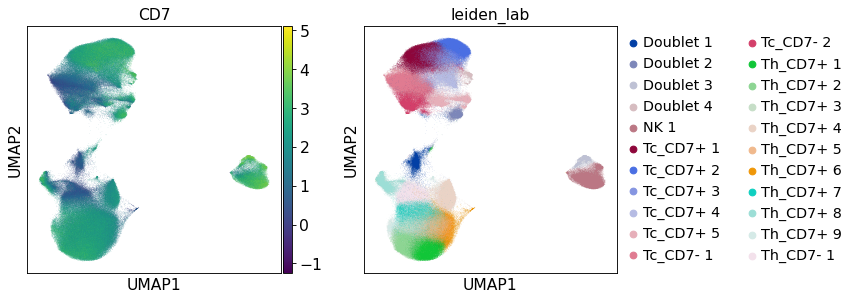

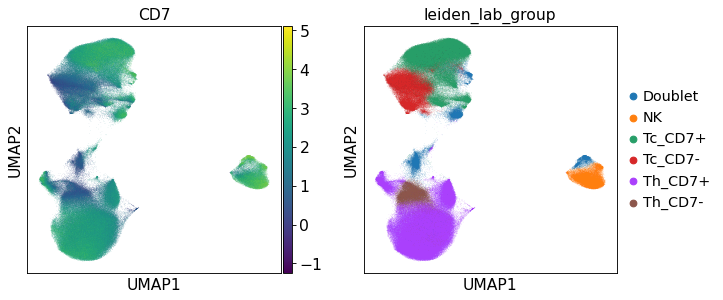

In [32]:
sc.pl.umap(adata_T_1, color=['CD7','leiden_lab'])
sc.pl.umap(adata_T_1, color=['CD7','leiden_lab_group'])

In [33]:
T_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.TNKIter1.h5ad')
print(T_file)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.TNKIter1.h5ad


In [34]:
save_adata(adata_T_1, T_file, gcs=gcs)

Only considering the two last: ['.TNKIter1', '.h5ad'].
Only considering the two last: ['.TNKIter1', '.h5ad'].


In [35]:
annot_file_in = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloid.h5ad')
print(annot_file_in)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloid.h5ad


In [36]:
adata_annot = read_adata(annot_file_in, gcs=gcs)

Only considering the two last: ['.SubclusterBMyeloid', '.h5ad'].
Only considering the two last: ['.SubclusterBMyeloid', '.h5ad'].


In [37]:
adata_annot.obs['SubclusteringGroup'].value_counts()

nan                      452681
Neut                     214724
Mono                     102997
B_IgMhi_CD27lo_CD1chi     70246
B_IgMlo_CD27hi_CD1chi     40238
B_IgMhi_CD27lo_CD1clo     30206
B_IgMlo_CD27hi_CD1clo     17183
Unassigned_APC             6124
cDC_CD1c+                  2308
Basophil                   1743
Plasmablast                1387
pDC                        1378
cDC_CD11c+                 1334
Doublet                    1009
Name: SubclusteringGroup, dtype: int64

In [38]:
adata_annot.obs['Subclustering'] = adata_annot.obs['Subclustering'].astype(str)
adata_annot.obs['SubclusteringGroup'] =adata_annot.obs['SubclusteringGroup'].astype(str)

In [39]:
adata_annot.obs.loc[adata_T_1.obs.index, 'Subclustering'] = adata_T_1.obs['leiden_lab']
adata_annot.obs.loc[adata_T_1.obs.index, 'SubclusteringGroup'] = adata_T_1.obs['leiden_lab_group']

In [40]:
pd.crosstab(adata_annot.obs['leiden_lab_group'], adata_annot.obs['SubclusteringGroup']).T

leiden_lab_group,B,Doublet,HLA-DR_high,Mono/DC,NK,Neut,Plasmablast,RBC,Tc,Th
SubclusteringGroup,,,,,,,,,,
B_IgMhi_CD27lo_CD1chi,70237,0,0,0,0,0,9,0,0,0
B_IgMhi_CD27lo_CD1clo,30202,0,0,0,0,0,4,0,0,0
B_IgMlo_CD27hi_CD1chi,40238,0,0,0,0,0,0,0,0,0
B_IgMlo_CD27hi_CD1clo,17183,0,0,0,0,0,0,0,0,0
Basophil,0,0,1743,0,0,0,0,0,0,0
Doublet,0,0,982,19,4718,8,0,0,12586,10779
Mono,0,0,121,102100,0,776,0,0,0,0
NK,0,0,0,0,29913,0,0,0,10,0
Neut,0,0,38,431,0,214255,0,0,0,0


In [41]:
annot_file_out = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.h5ad')
print(annot_file_out)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.h5ad


In [42]:
save_adata(adata_annot, annot_file_out, gcs=gcs)

Only considering the two last: ['.SubclusterBMyeloidTNK', '.h5ad'].
Only considering the two last: ['.SubclusterBMyeloidTNK', '.h5ad'].


... storing 'Subclustering' as categorical
... storing 'SubclusteringGroup' as categorical


In [43]:
adata_T_1.obs['leiden_lab'].value_counts()

Tc_CD7- 1    40129
Tc_CD7+ 1    36663
Th_CD7+ 1    30513
NK 1         29923
Tc_CD7+ 2    26674
Th_CD7+ 2    25607
Th_CD7- 1    24908
Th_CD7+ 3    23761
Th_CD7+ 4    23004
Th_CD7+ 5    22726
Tc_CD7+ 3    21803
Tc_CD7- 2    19751
Th_CD7+ 6    19141
Th_CD7+ 7    18669
Tc_CD7+ 4    15782
Tc_CD7+ 5    14713
Th_CD7+ 8    13196
Doublet 1    10984
Th_CD7+ 9    10562
Doublet 2     8760
Doublet 3     4747
Doublet 4     3592
Name: leiden_lab, dtype: int64

In [44]:

T_file1 = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.TNKIter1.h5ad')
print(T_file1)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.TNKIter1.h5ad


In [45]:
save_adata(adata_T_1, T_file1, gcs=gcs)

Only considering the two last: ['.TNKIter1', '.h5ad'].
Only considering the two last: ['.TNKIter1', '.h5ad'].


In [50]:
(adata_T_1.obs['leiden_lab_group']!='Doublet').value_counts()

True     417525
False     28083
Name: leiden_lab_group, dtype: int64

In [51]:
umap_genestoplot=['CD3', 'CD4', 'CD8', 'CD7', 'CD27', 'CD161', 'CD16', 'CD56']
_adata = adata_T_1[adata_T_1.obs['leiden_lab_group']!='Doublet', :].copy()

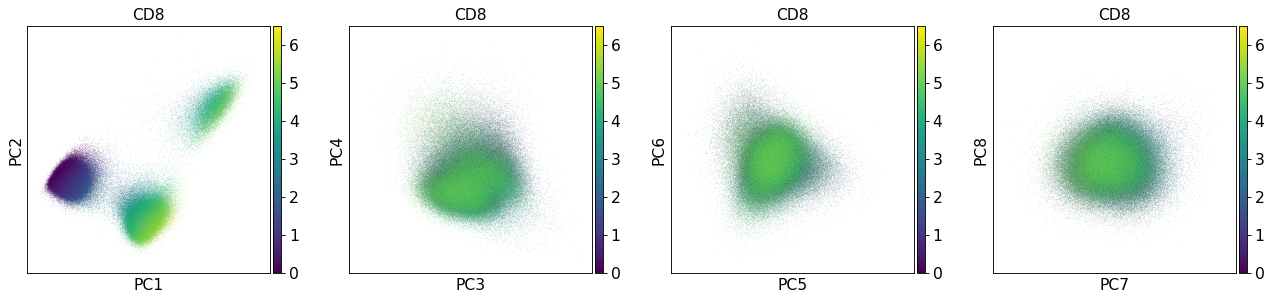

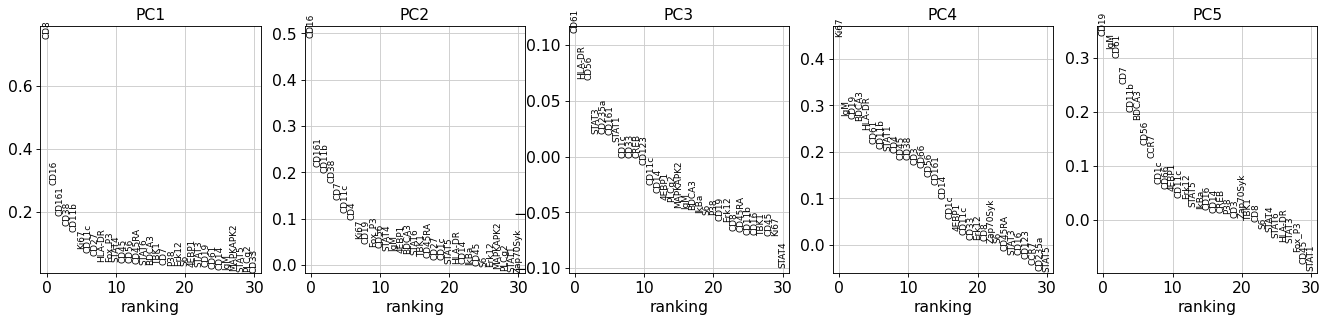

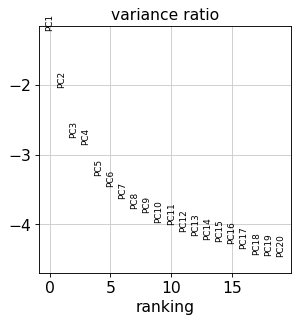

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:06:32)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:16:26)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (1:36:56)


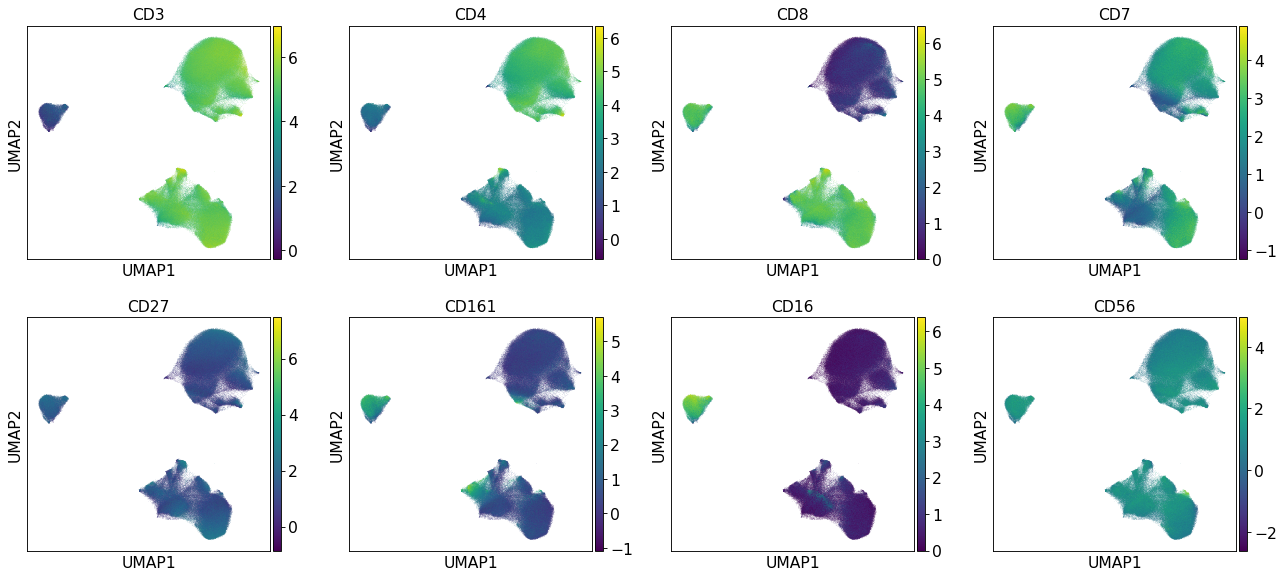

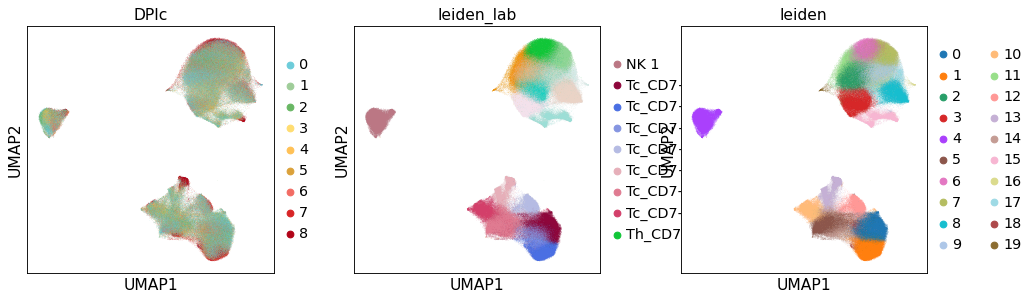

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,CD8,CD27,CREB,STAT1,CD16,CD8,CD4,CD4,CD61,CD38,CD161,CD4,CD61,Ki67,CD38,Ki67,CD19,CD4,CD19,CD11c
1,CD7,CCR7,CD4,CD4,CD161,CD235a,CD27,CD38,BDCA3,CD4,CD8,Fox_P3,BDCA3,CD8,CD8,CD4,CD4,CD7,CD45RA,CD1c
2,CREB,CD8,P38,CD235a,CD11b,STAT3,CD7,CD3,IgM,CREB,CD45,PLCg2,CD8,CD45,CD235a,CD45,IgM,CD3,CD8,CD235a
3,CCR7,CD7,CD7,CD33,CD11c,CD33,CD3,CD66,CD4,CD3,CD235a,IkBa,IgM,HLA-DR,CD123,HLA-DR,CD66,STAT1,CCR7,HLA-DR
4,STAT3,CD3,Erk12,CD45,CD38,CD123,CD66,CD27,CD19,CD56,CD33,STAT6,CD11b,CD38,CD33,STAT1,CD45RA,CD45,CD56,CD123
5,P38,STAT6,STAT3,CD56,CD7,CD61,CCR7,STAT6,CD11b,CD7,CD123,MAPKAPK2,CD19,STAT1,CD45RA,CD14,CD3,CD66,BDCA3,STAT6
6,Erk12,Fox_P3,CD3,CD123,Fox_P3,CD45,STAT6,CCR7,CD1c,CD66,CD45RA,STAT4,HLA-DR,CD14,PLCg2,IgM,CCR7,CD19,CD161,CD45RA
7,S6,CD66,STAT5,CD61,STAT4,HLA-DR,Fox_P3,CD7,CD11c,CCR7,STAT1,CD123,CD11c,BDCA3,HLA-DR,CD61,CD56,CCR7,CD11b,CD33


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,198.878693,195.507812,109.827110,159.124252,287.522156,150.466263,190.914185,194.603729,211.693909,128.068161,215.556274,85.678978,183.725937,191.883179,104.128532,171.601746,126.603348,133.505249,71.387810,-3.203495
1,129.974503,195.245087,92.244659,157.681961,249.590012,93.887016,122.423599,128.577423,146.594788,104.157654,121.280228,36.017311,137.029358,158.495605,84.134346,106.712990,93.022667,94.917297,51.243553,-7.280298
2,80.743927,186.702637,49.770504,89.962143,235.743179,68.357246,110.944633,127.163193,122.844925,63.891632,104.712219,35.068905,108.778862,127.990845,62.568474,95.872314,62.921703,92.617683,44.083324,-7.478669
3,75.158607,148.468155,39.361988,65.419220,230.485413,66.710213,100.290108,113.259178,77.695847,27.455530,63.929592,33.685905,107.567360,109.125694,59.691574,62.076775,56.494961,91.371620,43.459301,-8.549500
4,54.658455,126.954048,16.641731,56.391529,224.171753,63.623074,81.828300,83.793282,69.308777,26.114277,52.180595,31.091311,81.215797,84.565788,54.439751,56.063995,52.555981,85.821938,40.478497,-9.033811
5,47.154747,124.801346,12.090507,50.978024,169.362762,49.418808,73.380920,82.961220,66.048920,13.141444,48.862926,25.071365,66.386200,75.715561,51.936657,40.359222,41.453930,84.344307,34.872280,-9.181568
6,33.830940,119.928047,9.925819,47.140358,143.867630,36.782207,70.390228,81.862373,62.998623,10.032279,37.290188,21.990469,59.197319,69.175598,51.009369,38.106724,39.554020,51.696308,34.231281,-9.747351
7,21.556229,113.319504,0.756270,37.089100,138.877060,33.033245,64.762169,79.745216,53.476467,-9.119431,35.290886,13.124076,54.961582,64.364326,50.885487,33.498390,37.097672,43.495457,30.937582,-10.071264


In [53]:

npcs=10
n_neighbors=int(_adata.shape[0]*.0001)
min_dist=0.1
spread=2.0
resolution=2.0
pc_genestoplot=['CD8']
other_plot=['DPIc', 'leiden_lab', 'leiden']
random_state=14

pca_cytof(_adata)
sc.pl.pca(_adata, components=['1,2', '3,4', '5,6', '7,8'], color=pc_genestoplot,
          ncols=4)
sc.pl.pca_loadings(_adata, components=[1,2,3,4,5])
sc.pl.pca_variance_ratio(_adata, log=True)


sc.pp.neighbors(_adata, n_neighbors=n_neighbors, n_pcs=npcs, random_state=random_state,
                    use_rep='X_pca')
sc.tl.umap(_adata, min_dist=min_dist, spread=spread, random_state=random_state)
np.random.seed(random_state)
sc.tl.leiden(_adata, resolution=resolution, random_state=random_state)


fig = sc.pl.umap(_adata, color=umap_genestoplot)
fig = sc.pl.umap(_adata, color=other_plot)

sc.tl.rank_genes_groups(_adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(_adata.uns['rank_genes_groups']['names']).head(8))
display(pd.DataFrame(_adata.uns['rank_genes_groups']['scores']).head(8))
adata_T_2 = _adata.copy()

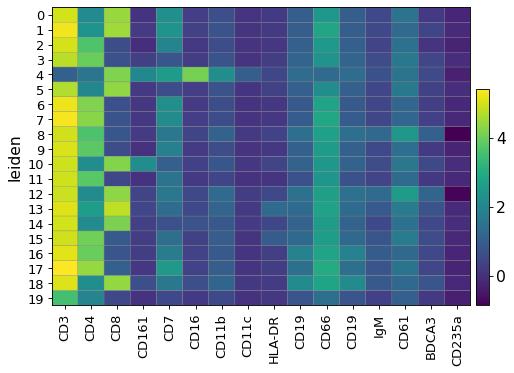

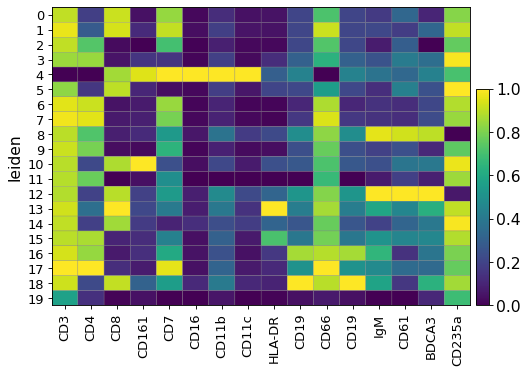

In [54]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD7', 'CD16', 'CD11b', 'CD11c', 'HLA-DR', 'CD19', 'CD66', 'CD19', 'IgM', 'CD61', 'BDCA3', 'CD235a']
gs = sc.pl.matrixplot(adata_T_2,marker_genes, groupby='leiden', figsize=(7,5))
gs = sc.pl.matrixplot(adata_T_2,marker_genes, groupby='leiden', figsize=(7,5), standard_scale='var')

In [58]:
main = ['Tc', 'Tc', 'Th', 'Th', 'NK', #0-4
        'Tc', 'Th', 'Th', 'Th', 'Th', #5-9
        'Tc', 'Th', 'Tc', 'Tc', 'Tc', #10-14
        'Th', 'Th', 'Th', 'Tc', 'Th']
cd7_stat = ['CD7hi', 'CD7hi', 'CD7hi','CD7lo', '',
            'CD7lo', 'CD7hi', 'CD7hi', 'CD7hi', 'CD7hi',
            'CD161hi_CD7lo', 'CD7hi', 'CD7hi', 'CD7hi', 'CD7lo', 
            'CD7hi', 'CD7hi', 'CD7hi', 'CD7hi', 'CD7lo']

fullcat = []
for i in range(len(main)):
    if cd7_stat[i] != '':
        fullcat.append(main[i]+'_'+cd7_stat[i])
    else:
        fullcat.append(main[i])        


        

labmap = {}
main_categories = set(main)
full_categories = set(fullcat)
main_counter = {c:1 for c in main_categories}
full_counter = {c:1 for c in fullcat}
for i in range(len(fullcat)):
    labmap[str(i)] = fullcat[i]+' '+str(full_counter[fullcat[i]])
    full_counter[fullcat[i]] += 1

In [59]:
adata_T_2.obs['leiden_lab'] = adata_T_2.obs['leiden'].replace(labmap)
adata_T_2.obs['leiden_lab_group'] = adata_T_2.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


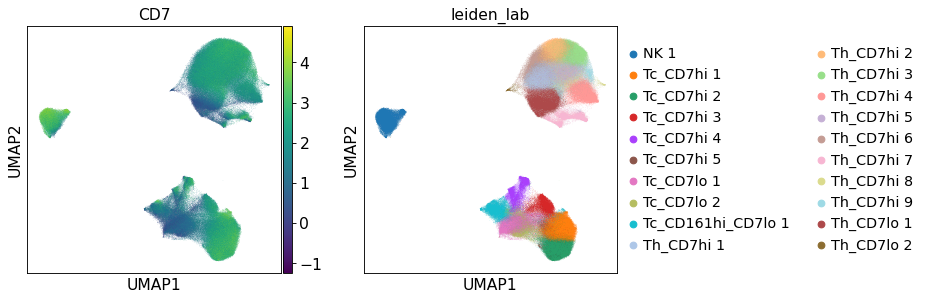

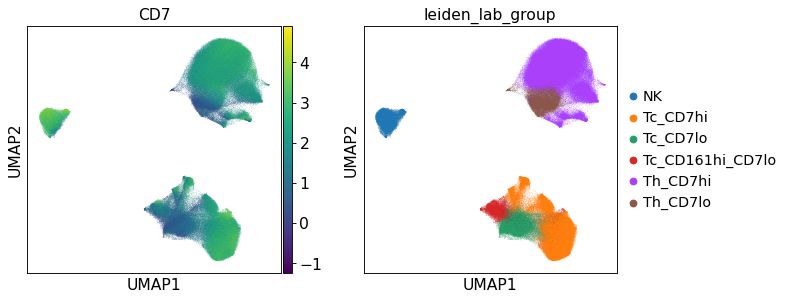

In [60]:
sc.pl.umap(adata_T_2, color=['CD7','leiden_lab'])
sc.pl.umap(adata_T_2, color=['CD7','leiden_lab_group'])

In [61]:
T_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.TNKIter2.h5ad')
print(T_file)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.TNKIter2.h5ad


In [62]:
save_adata(adata_T_2, T_file, gcs=gcs)

Only considering the two last: ['.TNKIter2', '.h5ad'].
Only considering the two last: ['.TNKIter2', '.h5ad'].


In [63]:
annot_file_in = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloid.h5ad')
print(annot_file_in)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloid.h5ad


In [64]:
adata_annot = read_adata(annot_file_in, gcs=gcs)

Only considering the two last: ['.SubclusterBMyeloid', '.h5ad'].
Only considering the two last: ['.SubclusterBMyeloid', '.h5ad'].


In [65]:
adata_annot.obs['SubclusteringGroup'].value_counts()

nan                      452681
Neut                     214724
Mono                     102997
B_IgMhi_CD27lo_CD1chi     70246
B_IgMlo_CD27hi_CD1chi     40238
B_IgMhi_CD27lo_CD1clo     30206
B_IgMlo_CD27hi_CD1clo     17183
Unassigned_APC             6124
cDC_CD1c+                  2308
Basophil                   1743
Plasmablast                1387
pDC                        1378
cDC_CD11c+                 1334
Doublet                    1009
Name: SubclusteringGroup, dtype: int64

In [67]:
adata_annot.obs['Subclustering'] = adata_annot.obs['Subclustering'].astype(str)
adata_annot.obs['SubclusteringGroup'] =adata_annot.obs['SubclusteringGroup'].astype(str)

In [68]:
adata_annot.obs.loc[adata_T_2.obs.index, 'Subclustering'] = adata_T_2.obs['leiden_lab']
adata_annot.obs.loc[adata_T_2.obs.index, 'SubclusteringGroup'] = adata_T_2.obs['leiden_lab_group']

In [69]:
pd.crosstab(adata_annot.obs['leiden_lab_group'], adata_annot.obs['SubclusteringGroup']).T

leiden_lab_group,B,Doublet,HLA-DR_high,Mono/DC,NK,Neut,Plasmablast,RBC,Tc,Th
SubclusteringGroup,,,,,,,,,,
B_IgMhi_CD27lo_CD1chi,70237,0,0,0,0,0,9,0,0,0
B_IgMhi_CD27lo_CD1clo,30202,0,0,0,0,0,4,0,0,0
B_IgMlo_CD27hi_CD1chi,40238,0,0,0,0,0,0,0,0,0
B_IgMlo_CD27hi_CD1clo,17183,0,0,0,0,0,0,0,0,0
Basophil,0,0,1743,0,0,0,0,0,0,0
Doublet,0,0,982,19,0,8,0,0,0,0
Mono,0,0,121,102100,0,776,0,0,0,0
NK,0,0,0,0,29911,0,0,0,13,0
Neut,0,0,38,431,0,214255,0,0,0,0


In [70]:
annot_file_out = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.h5ad')
print(annot_file_out)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.h5ad


In [71]:
save_adata(adata_annot, annot_file_out, gcs=gcs)

Only considering the two last: ['.SubclusterBMyeloidTNK', '.h5ad'].
Only considering the two last: ['.SubclusterBMyeloidTNK', '.h5ad'].


... storing 'Subclustering' as categorical
... storing 'SubclusteringGroup' as categorical


In [141]:
expression_full = pd.DataFrame(adata_T_2.X, index=adata_T_2.obs.index, columns=adata_T_2.var.index)

In [142]:
obs = adata_T_2.obs.copy()

In [143]:
adata_T_2.obs['leiden_lab_group'].unique()

[Th_CD7hi, NK, Tc_CD7hi, Tc_CD161hi_CD7lo, Th_CD7lo, Tc_CD7lo]
Categories (6, object): [Th_CD7hi, NK, Tc_CD7hi, Tc_CD161hi_CD7lo, Th_CD7lo, Tc_CD7lo]

In [144]:
genes_to_plot = ['CD3', 'CD4', 'CD8', 'CD7', 'CD16', 'CD161']
celltype_order = ['Th_CD7hi', 'Th_CD7lo', 'Tc_CD7hi', 'Tc_CD7lo', 'Tc_CD161hi_CD7lo', 'NK']
celltype_order_clean = [x.replace('_', ' ').replace('Th', 'T CD4+').replace('Tc', 'T CD8+') for x in celltype_order]
obs['Grouped_Clustering'] = pd.Categorical(obs['leiden_lab_group'].apply(lambda x: x.replace('_', ' ').replace('Th', 'T CD4+').replace('Tc', 'T CD8+')).values, categories=celltype_order_clean)
expression = expression_full.loc[:, genes_to_plot]
obs['UMAP_1'] = adata_T_2.obsm['X_umap'][:,0]
obs['UMAP_2'] = adata_T_2.obsm['X_umap'][:,1]

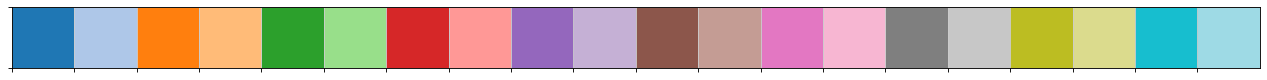

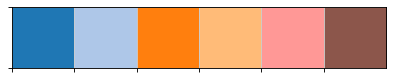

In [145]:
allcolors = palettable.tableau.Tableau_20.hex_colors
sns.palplot(allcolors)

ctcolors = [allcolors[0], allcolors[1],  allcolors[2], allcolors[3],allcolors[7],  allcolors[10]]

ctmap = dict(zip(celltype_order_clean, ctcolors))
sns.palplot([ctmap[x] for x in celltype_order_clean])

obs['ctcolor'] = obs['Grouped_Clustering'].replace(ctmap)

In [159]:
from matplotlib import gridspec
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

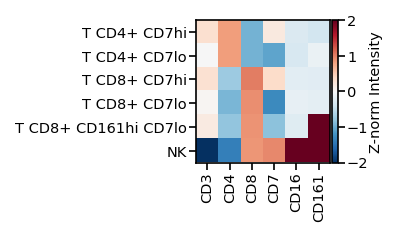

In [160]:
expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(obs['Grouped_Clustering']).mean()

width=2.5
heatmap_width=1.6
legend_width=.6
left_space=.5

heatmap_height = .95
bottom_space = .42
top_space = .13
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

allcolors = average_expression.copy()
vmin=-2.
vmax=2.
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order_clean, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order_clean)))
heatmap_ax.set_yticklabels(celltype_order_clean)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)
#heatmap_ax.set_title('T/NK - CyTOF', pad=0)
'''
for (x, g) in enumerate(genes_to_plot):
    for (y, ct) in enumerate(celltype_order):
        dotsize = alldotsize.loc[ct,g]
        heatmap_ax.scatter(x, y, color="none", marker='o',
                                      s=dotsize, norm=None,
                                       edgecolor='k', linewidth=.5)
'''
        
        
        

plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 10) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .3

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.45, .82, 5)

sizelegendfontsize = 7
size_legend_ax.text(.65, .5, 'Z-norm Intensity', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)
    
figure_file = os.path.join(results_dir, "Subcluster.TNK.Cytof.Invivo.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


In [152]:
box_height=1.5
box_width=1.5
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.5
valdpi = 200

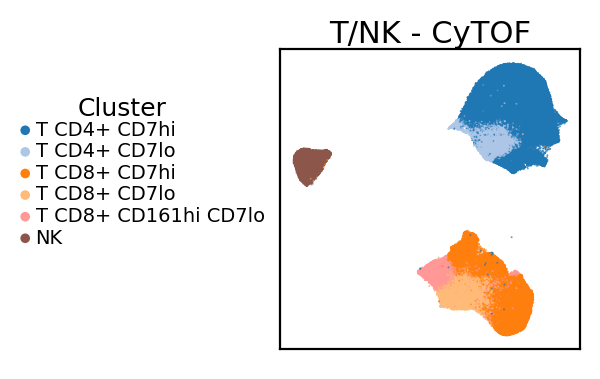

In [158]:
leg_width=1.3
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(leg_width, box_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(obs['UMAP_1'], obs['UMAP_2'], c=obs['ctcolor'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

marker_x=.02
N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.73, .37, num=N)):
    ct = celltype_order_clean[i]
    legend_ax.scatter(marker_x, y, color=ctmap[ct], s=12, edgecolor='None')
    legend_ax.text(marker_x+.04, y-.015, ct, fontsize=7)
legend_ax.text(.22, .78, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'T/NK - CyTOF', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "Subcluster.UMAP.TNK.Cytof.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)

True     417525
False     28083
Name: leiden_lab_group, dtype: int64